## Objective

**Cryptocurrency prediction experiment** to predict direction of the close price of BTCUSDT for the next 10 hours

Dataset:
- BTCUSDT 1h in Json format from Binance

Prediction target logic:
- Set treshold to +-1%
- If next 10 hours close price is higher than 1% of current close price, label as 1
- If next 10 hours close price is lower than -1% of current close price, label as -1
- Else label as 0

Since we focus on the direction of the price, we will use classification model for this experiment

In [1]:
import pandas as pd

# Ref from data exploration
def remove_outlier(df, iqr_threshold = 5):
    
    # Calculate the first quartile (25th percentile) and third quartile (75th percentile)
    q1 = df['volume'].quantile(0.25)
    q3 = df['volume'].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Define lower and upper bounds for outliers
    lower_bound = q1 - iqr_threshold * iqr
    upper_bound = q3 + iqr_threshold * iqr

    lower_bound = 0 if lower_bound < 0 else lower_bound

    # remove outliers from df
    df = df[(df['volume'] > lower_bound) & (df['volume'] < upper_bound)]
    
    return df

def read_hist_data(name = 'BTC', timeframe = '1h'):
    file_path = f"./data/{name}_USDT-{timeframe}.json"
    df = pd.read_json(file_path)

    # set column names
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

    # convert unix timestamp to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
    
    df = remove_outlier(df)
    return df

random_state = 55

## Feature Engineering

In [2]:
df = read_hist_data(name = 'BTC', timeframe = '1h') # read data
# df = read_hist_data(name = 'BTC', timeframe = '5m') # read data
print(df.head(10))
print(df.tail(10)) 

df.describe()

             datetime      open      high       low     close       volume
0 2021-01-01 00:00:00  28923.63  29031.34  28690.17  28995.13  2311.811445
1 2021-01-01 01:00:00  28995.13  29470.00  28960.35  29409.99  5403.068471
2 2021-01-01 02:00:00  29410.00  29465.26  29120.03  29194.65  2384.231560
3 2021-01-01 03:00:00  29195.25  29367.00  29150.02  29278.40  1461.345077
4 2021-01-01 04:00:00  29278.41  29395.00  29029.40  29220.31  2038.046803
5 2021-01-01 05:00:00  29220.31  29235.28  29084.11  29187.01  1469.956262
6 2021-01-01 06:00:00  29187.01  29270.00  29077.32  29174.35  1420.726291
7 2021-01-01 07:00:00  29174.35  29191.98  28806.54  29092.83  2380.180918
8 2021-01-01 08:00:00  29092.84  29178.03  28872.24  29000.01  2008.165739
9 2021-01-01 09:00:00  29000.01  29307.73  28970.00  29202.21  2022.056022
                 datetime      open      high       low     close      volume
23121 2023-08-22 23:00:00  25808.00  26070.04  25784.69  26056.00  2291.04723
23122 2023-08-23 00

,datetime,open,high,low,close,volume
count,22915,22915.000000,22915.000000,22915.000000,22915.000000,22915.000000
mean,2022-04-26 04:37:59.869081600,35117.336473,35297.705123,34928.163154,35117.620848,4477.749672
min,2021-01-01 00:00:00,15648.230000,15769.990000,15476.000000,15649.520000,5.887034
25%,2021-08-28 09:30:00,23415.510000,23483.855000,23341.975000,23414.470000,1398.628235
50%,2022-04-24 06:00:00,32099.970000,32345.000000,31800.000000,32099.980000,2658.617538
75%,2022-12-22 12:30:00,45197.645000,45485.530000,44869.145000,45197.975000,5828.032940
max,2023-08-23 08:00:00,68635.120000,69000.000000,68451.190000,68633.690000,28721.893750
std,NaN,13125.131469,13210.580569,13033.198250,13125.379765,4697.700455


### Experiment 1: Create features from indicators

Use TAlib (Technical Analysis Library) in Python to create technical indicators that might have prediction power.
- We will explore all available data whixh is Open, High, Low, Close, Volume
- We will focus in index type indicators since it's more generalizable to other stocks

In [3]:
import talib
import numpy as np
import warnings



def get_features(df):

    # List of periods
    periods = [4, 12, 24, 48, 100, 200]
    inputs = ['high', 'low', 'close', 'volume']

    
    # loop periods and inputs
    for period in periods:
        for input in inputs:
            # Generate indicators

            # % of change
            df[f'{input}_pct_{period}'] = df[input].pct_change(periods=period) * 100

            # % of ema
            pct_ema = talib.EMA(df[input].values, timeperiod=period)
            df[f'{input}_ema_{period}'] = (df[input] - pct_ema) / pct_ema * 100

            # RSI
            df[f'{input}_rsi_{period}'] = talib.RSI(df[input].values, timeperiod=period)

            # TRIX
            df[f'{input}_trix_{period}'] = talib.TRIX(df[input].values, timeperiod=period)

            # SD
            pct_sd = talib.STDDEV(df[input].values, timeperiod=period)
            df[f'{input}_sd_{period}'] = pct_sd / df[input] * 100

            # ROC
            df[f'{input}_roc_{period}'] = talib.ROC(df[input].values, timeperiod=period)

            # VAR
            df[f'{input}_var_{period}'] = talib.VAR(df[input].values, timeperiod=period)

            # Lagged

            # pct change - lagged 1
            df[f'{input}_lag1_{period}'] = df[f'{input}_pct_{period}'].shift(1)

            # pct change - lagged 2
            df[f'{input}_lag2_{period}'] = df[f'{input}_pct_{period}'].shift(2)

            


        
        # Multiple inputs indicators
        # ATR
        pct_atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df[f'price_atr_{period}'] = pct_atr / df['close'] * 100

        # Price interaction Features:
        df[f'price_interact_{period}'] = df[f'close_roc_{period}'] * df[f'price_atr_{period}']

        # Price volume interaction:
        df[f'pv_interact_{period}'] = df[f'close_roc_{period}'] * df[f'volume_roc_{period}']

        # ADX
        df[f'price_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        # MFI
        df[f'mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

        # DX
        df[f'price_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

    return df

# to predict if the price will go up (+1%) or down (-1%) in the next 10 periods
def get_target_next_close(df, target_shift = 10):

    target_treshold = 0.01
    conditions = [
        (df['close'].shift(target_shift * -1) > df['close'] * (1+target_treshold )),
        (df['close'].shift(target_shift * -1) < df['close'] * (1-target_treshold)),
        (df['close'].shift(target_shift * -1) >= df['close'] * (1-target_treshold)) & 
        (df['close'].shift(target_shift * -1) <= df['close'] * (1+target_treshold))
    ]
    values = [1, -1, 0]
    df['target'] = np.select(conditions, values)
    df = df.dropna()
    return df

def get_features_target_next_close():

    # Disable the PerformanceWarning temporarily
    warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

    df = read_hist_data()
    df = get_features(df)
    df = get_target_next_close(df)

    # Re-enable warnings
    warnings.resetwarnings()

    return df

df = get_features_target_next_close()

print(df.head(5))
print(df.tail(5))



               datetime      open      high       low     close       volume  \
598 2021-01-25 22:00:00  32715.53  32732.99  31910.00  32462.36  3761.903244   
599 2021-01-25 23:00:00  32462.38  32650.00  32201.44  32254.20  2777.021592   
600 2021-01-26 00:00:00  32254.19  32793.01  31758.00  32474.33  3799.041198   
601 2021-01-26 01:00:00  32474.34  32827.33  32210.01  32758.85  2324.035401   
602 2021-01-26 02:00:00  32754.20  32765.41  32230.29  32307.97  2168.256682   

     high_pct_4  high_ema_4  high_rsi_4  high_trix_4  ...  volume_var_200  \
598   -3.815782   -1.716759    8.849644    -0.469483  ...    5.152259e+06   
599   -3.369146   -1.188915    8.175968    -0.579663  ...    5.155260e+06   
600   -2.034151   -0.455044   21.845644    -0.576277  ...    5.155131e+06   
601   -1.903168   -0.210814   25.399214    -0.506497  ...    5.153162e+06   
602    0.099044   -0.239807   22.894982    -0.426357  ...    5.140007e+06   

     volume_lag1_200  volume_lag2_200  price_atr_200  pr

In [4]:
# total columns
print(f'Total columns: {len(df.columns)}')

# list(df.columns)

Total columns: 259


##### Identify the most important features

When dealing with a large number of features, it's crucial to determine which features are most relevant for predicting your target variable. Feature selection techniques can help you identify the most relevant features, reduce overfitting, improve accuracy, and reduce training time.

We will use a **Tree-Based Model** to rank the importance of each feature.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is the DataFrame with features and target variable
# Separate features and target
X = df.drop(columns=['datetime', 'target'])
y = df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# Initialize and train the model
clf = RandomForestClassifier(random_state=random_state)
clf.fit(X_train, y_train)

# Get feature importances
feature_importances = clf.feature_importances_

# Sort feature importances in descending order and get the indices
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
feature_names = [X.columns[i] for i in indices]



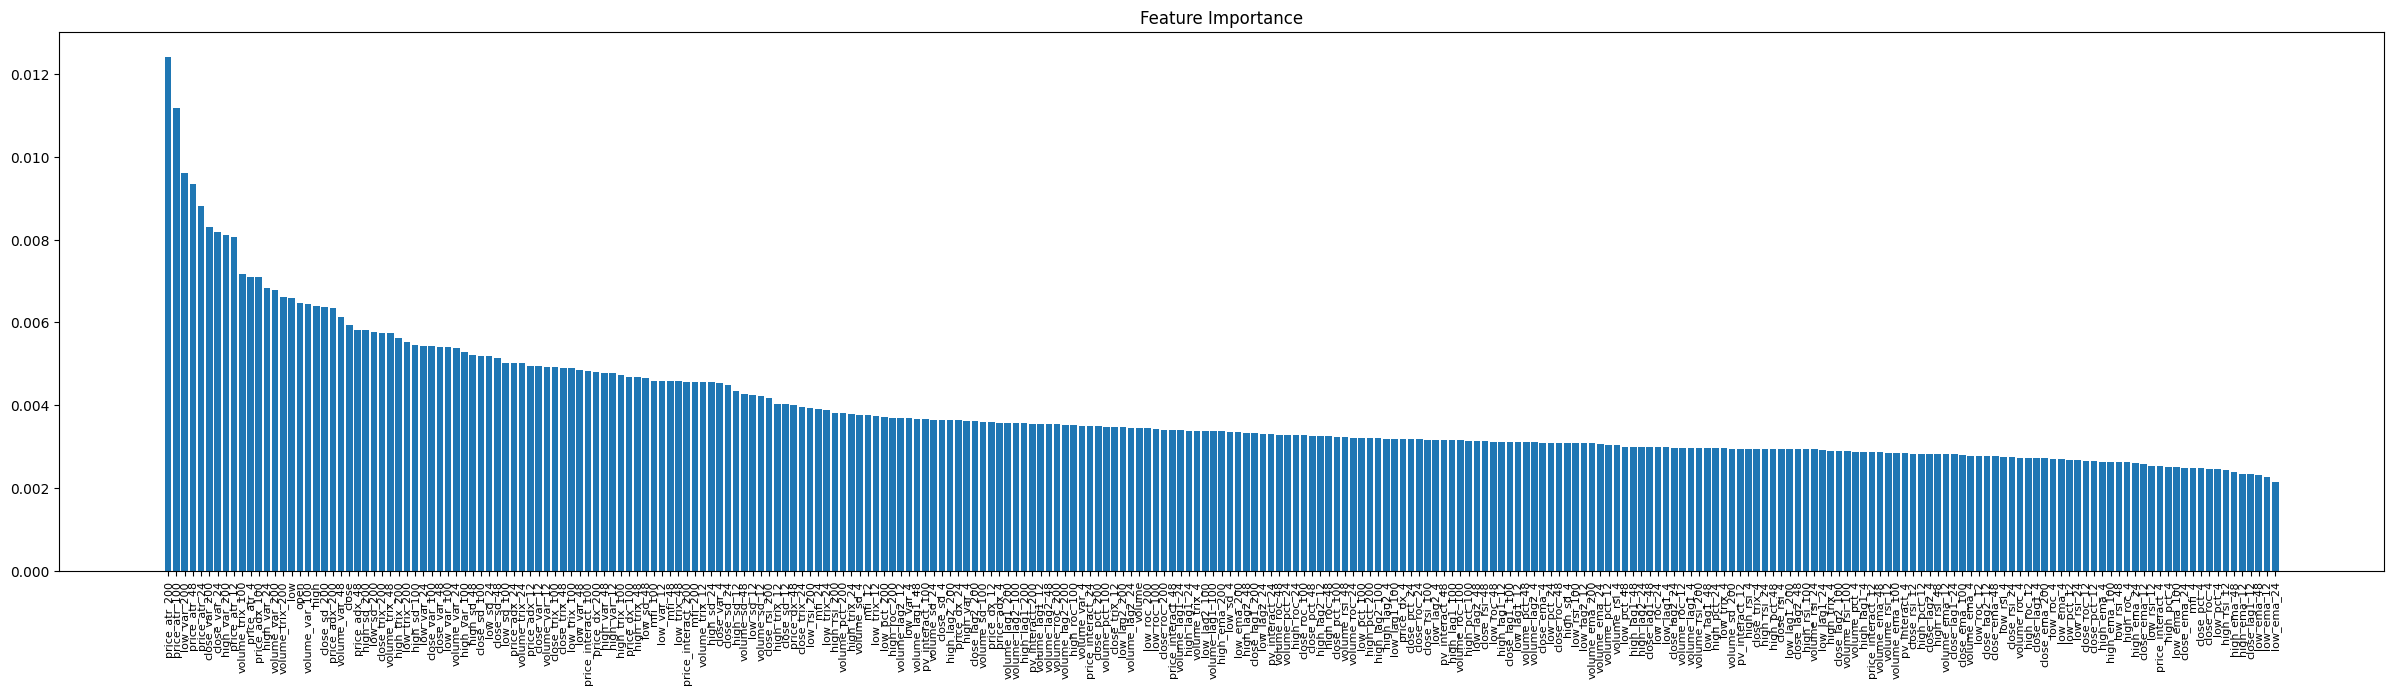

Total features: 257
Top 25 important features:  ['price_atr_200', 'price_atr_100', 'low_var_200', 'price_atr_48', 'price_atr_24', 'close_var_200', 'close_var_24', 'high_var_200', 'price_atr_12', 'volume_trix_100', 'price_atr_4', 'price_adx_100', 'high_var_24', 'volume_var_200', 'volume_trix_200', 'low', 'open', 'volume_var_100', 'high', 'close_sd_200', 'price_adx_200', 'volume_var_48', 'close', 'price_adx_48', 'high_sd_200']
Least 25 important features:  ['low_rsi_24', 'close_roc_12', 'close_pct_12', 'high_ema_4', 'high_ema_100', 'low_rsi_48', 'high_roc_4', 'high_ema_24', 'close_ema_12', 'low_rsi_12', 'price_interact_4', 'high_pct_4', 'low_ema_100', 'close_ema_24', 'mfi_4', 'close_pct_4', 'close_roc_4', 'low_pct_4', 'high_rsi_12', 'high_ema_48', 'high_ema_12', 'close_lag1_12', 'low_ema_48', 'low_ema_12', 'low_ema_24']


In [24]:
# Create a plot
plt.figure(figsize=(30, 7))

# Create plot title
plt.title("Feature Importance")

# Add bars for each feature, small font size to fit the features
plt.bar(range(X.shape[1]), feature_importances[indices] )

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), feature_names, rotation=90, fontsize = 8)

# Show plot
plt.show()

# print total features
print(f'Total features: {len(feature_names)}')

# print most important 25 features
print("Top 25 important features: ", feature_names[:25])

# print least important 25 features
print("Least 25 important features: ", feature_names[-25:])


The feature importances give valuable insights into what the model views as the most and least predictive features. 

##### Interpretation

1. **Price ATR (Average True Range)**: The top important features are different periods of 'price_atr', suggesting that the model finds the Average True Range of different timeframes quite significant in predicting the future price direction. ATR is often used as a volatility measure.

2. **Variance (VAR)**: Variance for 'low', 'high', and 'close' prices for various periods like 200 and 24 are among the important features, suggesting that the model uses past price fluctuation as a strong signal.

3. **ADX (Average Directional Movement Index)**: Features like 'price_adx_100' and 'price_adx_200' are also considered important by the model, possibly because ADX measures the strength of the trend.

4. **TRIX**: Interestingly, 'volume_trix_100' and 'volume_trix_200' appear among the top features, suggesting that the model finds TRIX (a momentum oscillator) for volume crucial in making decisions.

5. **Direct Price Features**: The model also considers features like 'low', 'open', 'high', and 'close' as important, suggesting the raw values themselves have significant predictive power.

##### Least Important Features

On the other end, 
- It seems like RSIs, EMAs, and ROCs for various periods and price types are among the least important features according to the model. 
- We might consider eliminating these from thr feature set for the sake of simplicity and computational efficiency

##### Next Steps

**Feature Reduction**: Consider dropping the least important features to reduce the complexity.

----

### Experiment 2: Pre-process the data

Pre-processing the data can often lead to better model performance.

- First, calcualte baseline metrics for the model performance

In [25]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Predict labels for the test set
y_pred = clf.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average if classes are imbalanced
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:0.4f}")
print(f"F1-Score: {f1:0.4f}")
print(f"Precision: {precision:0.4f}")
print(f"Recall: {recall:0.4f}")


Accuracy: 0.7605
F1-Score: 0.7539
Precision: 0.7725
Recall: 0.7605


##### 1. Normalization / Standardization: 

Scale the features to have a mean of 0 and standard deviation of 1.

In [29]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Retrain the model on scaled data
clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_new = clf.predict(X_test_scaled)

# Compute metrics for the retrained model
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new, average='weighted')
precision_new = precision_score(y_test, y_pred_new, average='weighted')
recall_new = recall_score(y_test, y_pred_new, average='weighted')


In [37]:
# Compare new metrics with baseline
print(f"New Accuracy: {accuracy_new:0.4f}, Baseline: {accuracy:0.4f}. Difference : {(accuracy_new - accuracy)*100:0.2f} %")
print(f"New F1-Score: {f1_new}, Baseline: {f1}, Difference : {(f1_new - f1)*100:0.2f} %")
print(f"New Precision: {precision_new}, Baseline: {precision},  Difference : {(precision_new - precision)*100:0.2f} %")
print(f"New Recall: {recall_new}, Baseline: {recall}, Difference : {(recall_new - recall)*100:0.2f} %")

New Accuracy: 0.7633, Baseline: 0.7605. Difference : 0.28 %
New F1-Score: 0.7570411244964756, Baseline: 0.7539448267015957, Difference : 0.31 %
New Precision: 0.7750994971328324, Baseline: 0.7725319101325274,  Difference : 0.26 %
New Recall: 0.7632915173237754, Baseline: 0.7604540023894862, Difference : 0.28 %


##### 2. Handling Imbalanced Data

Data imbalance is a common issue in classification tasks, and techniques like SMOTE can help address this by generating synthetic samples in the feature space. 

**SMOTE (Synthetic Minority Over-sampling Technique)**

In [39]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=random_state)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)


In [42]:
# Retrain the model on smote data
clf.fit(X_train_res, y_train_res)

# Make predictions
y_pred_new = clf.predict(X_test_scaled)

# Compute metrics for the retrained model
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new, average='weighted')
precision_new = precision_score(y_test, y_pred_new, average='weighted')
recall_new = recall_score(y_test, y_pred_new, average='weighted')

In [43]:
# Compare new metrics with baseline
print(f"New Accuracy: {accuracy_new:0.4f}, Baseline: {accuracy:0.4f}. Difference : {(accuracy_new - accuracy)*100:0.2f} %")
print(f"New F1-Score: {f1_new}, Baseline: {f1}, Difference : {(f1_new - f1)*100:0.2f} %")
print(f"New Precision: {precision_new}, Baseline: {precision},  Difference : {(precision_new - precision)*100:0.2f} %")
print(f"New Recall: {recall_new}, Baseline: {recall}, Difference : {(recall_new - recall)*100:0.2f} %")

New Accuracy: 0.7852, Baseline: 0.7605. Difference : 2.48 %
New F1-Score: 0.7851594875329512, Baseline: 0.7539448267015957, Difference : 3.12 %
New Precision: 0.7850933073529637, Baseline: 0.7725319101325274,  Difference : 1.26 %
New Recall: 0.7852449223416965, Baseline: 0.7604540023894862, Difference : 2.48 %


**ADASYN (Adaptive Synthetic Sampling)**

Similar to SMOTE but generates samples based on the density of the minority class.

In [44]:
from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=random_state)
X_train_res, y_train_res = ada.fit_resample(X_train_scaled, y_train)


In [45]:
# Retrain the model on smote data
clf.fit(X_train_res, y_train_res)

# Make predictions
y_pred_new = clf.predict(X_test_scaled)

# Compute metrics for the retrained model
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new, average='weighted')
precision_new = precision_score(y_test, y_pred_new, average='weighted')
recall_new = recall_score(y_test, y_pred_new, average='weighted')

In [46]:
# Compare new metrics with baseline
print(f"New Accuracy: {accuracy_new:0.4f}, Baseline: {accuracy:0.4f}. Difference : {(accuracy_new - accuracy)*100:0.2f} %")
print(f"New F1-Score: {f1_new}, Baseline: {f1}, Difference : {(f1_new - f1)*100:0.2f} %")
print(f"New Precision: {precision_new}, Baseline: {precision},  Difference : {(precision_new - precision)*100:0.2f} %")
print(f"New Recall: {recall_new}, Baseline: {recall}, Difference : {(recall_new - recall)*100:0.2f} %")

New Accuracy: 0.7766, Baseline: 0.7605. Difference : 1.61 %
New F1-Score: 0.7769090779472217, Baseline: 0.7539448267015957, Difference : 2.30 %
New Precision: 0.7778315907753625, Baseline: 0.7725319101325274,  Difference : 0.53 %
New Recall: 0.7765830346475507, Baseline: 0.7604540023894862, Difference : 1.61 %


The results after applying SMOTE and ADASYN for handling imbalanced data show a clear improvement over the baseline in all metrics.

##### Observations:

- Both SMOTE and ADASYN improved the model's performance compared to the baseline across all metrics.
- SMOTE had a greater positive impact on F1-score and Accuracy compared to ADASYN.
- In Precision, SMOTE also outperformed ADASYN, albeit by a smaller margin.
- The improvements in Recall were fairly close for both SMOTE and ADASYN.

Based on these results, we proceed with the model trained using the **SMOTE** technique, as it shows the most substantial improvement in metrics across the board.

Note:
- Over-sampling techniques like SMOTE and ADASYN could potentially lead to overfitting


##### 3. Feature Decomposition:

PCA (Principal Component Analysis) is a popular technique for reducing the number of features by projecting them onto a lower-dimensional space.

In [54]:
# Apply SMOTE
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [64]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.80)
X_train_pca = pca.fit_transform(X_train_res)
X_test_pca = pca.transform(X_test_scaled)


In [65]:
# Retrain the model on smote data
clf.fit(X_train_pca, y_train_res)

# Make predictions
y_pred_new = clf.predict(X_test_pca)

# Compute metrics for the retrained model
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new, average='weighted')
precision_new = precision_score(y_test, y_pred_new, average='weighted')
recall_new = recall_score(y_test, y_pred_new, average='weighted')

In [66]:
# Compare new metrics with baseline
print(f"New Accuracy: {accuracy_new:0.4f}, Baseline: {accuracy:0.4f}. Difference : {(accuracy_new - accuracy)*100:0.2f} %")
print(f"New F1-Score: {f1_new}, Baseline: {f1}, Difference : {(f1_new - f1)*100:0.2f} %")
print(f"New Precision: {precision_new}, Baseline: {precision},  Difference : {(precision_new - precision)*100:0.2f} %")
print(f"New Recall: {recall_new}, Baseline: {recall}, Difference : {(recall_new - recall)*100:0.2f} %")

New Accuracy: 0.6456, Baseline: 0.7605. Difference : -11.48 %
New F1-Score: 0.645180521410249, Baseline: 0.7539448267015957, Difference : -10.88 %
New Precision: 0.6447899935336835, Baseline: 0.7725319101325274,  Difference : -12.77 %
New Recall: 0.6456093189964157, Baseline: 0.7604540023894862, Difference : -11.48 %


PCA seems to have led to a decrease in performance across all evaluation metrics:

##### Observations:

- All performance metrics have deteriorated compared to the baseline model.
- The most significant drop occurred in Precision, followed by Accuracy, Recall, and F1-Score.

----

### Experiment 3: Test alternative models

We will compare multiple classifiers against baseline RandomForest model, we will create a pipeline that will loop through various classifiers and evaluate them based on their **accuracy**.

##### Rewrite baseline model

We will include scaling and SMOTE in pipeline. However, we will not include PCA in the pipeline since it didn't yield favorable results in the previous experiment.

In [8]:
## Rewrite latest model as baseline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

random_state = 55

# Separate features and target
X = df.drop(columns=['datetime', 'target'])
y = df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
sm = SMOTE(random_state=random_state)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Initialize and train the model
clf = RandomForestClassifier(random_state=random_state)
clf.fit(X_train_res, y_train_res)

# Predict labels for the test set
y_pred = clf.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average if classes are imbalanced
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:0.4f}")
print(f"F1-Score: {f1:0.4f}")
print(f"Precision: {precision:0.4f}")
print(f"Recall: {recall:0.4f}")

Accuracy: 0.7851
F1-Score: 0.7850
Precision: 0.7850
Recall: 0.7851


Import the following classifiers and necessary modules:

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
import lightgbm as lgb

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

We will include cross-validation into model comparison pipeline to get a more robust estimate of each model's performance.

Random Forest (Baseline): Mean Accuracy: 0.8854, Standard Deviation: 0.0212 - Duration: 0.19 minutes
Logistic Regression: Mean Accuracy: 0.5011, Standard Deviation: 0.0121 - Duration: 1.18 minutes
SVM linear: Mean Accuracy: 0.5067, Standard Deviation: 0.0115 - Duration: 18.25 minutes
SVM rbf: Mean Accuracy: 0.6423, Standard Deviation: 0.0228 - Duration: 3.79 minutes
Decision Tree: Mean Accuracy: 0.7416, Standard Deviation: 0.0304 - Duration: 0.59 minutes
K-Nearest Neighbors: Mean Accuracy: 0.8103, Standard Deviation: 0.0309 - Duration: 0.03 minutes
Naive Bayes: Mean Accuracy: 0.3964, Standard Deviation: 0.0069 - Duration: 0.00 minutes
Gradient Boosting: Mean Accuracy: 0.6313, Standard Deviation: 0.0317 - Duration: 36.72 minutes
AdaBoost: Mean Accuracy: 0.4881, Standard Deviation: 0.0218 - Duration: 2.31 minutes
LightGBM: Mean Accuracy: 0.8026, Standard Deviation: 0.0413 - Duration: 0.11 minutes


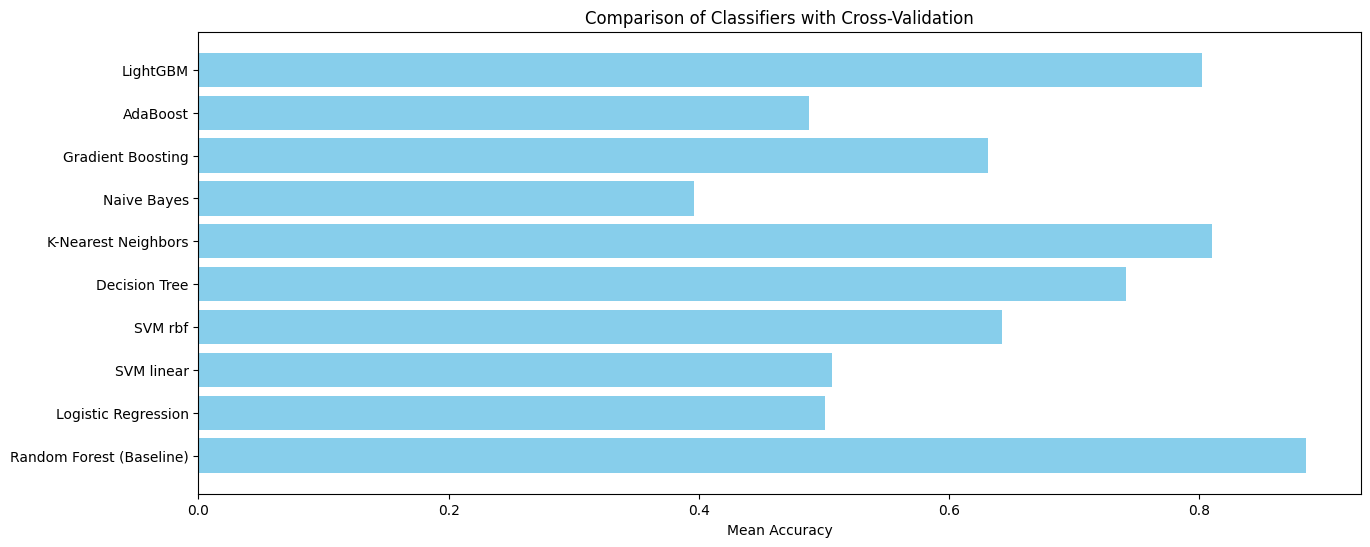

In [43]:
import time

# Define classifiers to test
classifiers = {
    "Random Forest (Baseline)": RandomForestClassifier(random_state=random_state, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=10000, n_jobs=-1),
    "SVM linear": SVC(kernel='linear', random_state=random_state),
    "SVM rbf": SVC(kernel='rbf', random_state=random_state),
    "Decision Tree": DecisionTreeClassifier(random_state=random_state),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
    "AdaBoost": AdaBoostClassifier(random_state=random_state),
    'LightGBM': lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1),
}

# Initialize an empty dictionary to store the results
results = {}

# Loop through classifiers
for name, clf in classifiers.items():
    # Calculate execute start time
    start = time.time()

    # Define pipeline
    pipeline = Pipeline([
        ('model', clf)
    ])
    
    # Perform 5-fold cross-validation
    scores = cross_val_score(pipeline, X_train_res, y_train_res, scoring='accuracy', cv=5)
    
    # Store mean and standard deviation of scores
    results[name] = (scores.mean(), scores.std())

    # Calculate execute duration
    duration = time.time() - start
    
    # Print results
    print(f"{name}: Mean Accuracy: {scores.mean():.4f}, Standard Deviation: {scores.std():.4f} - Duration: {duration/60:.2f} minutes")

# Optionally, plot the results
names = list(results.keys())
values = [x[0] for x in results.values()]  # Extract the mean accuracy values

plt.figure(figsize=(15, 6))
plt.barh(names, values, color='skyblue')
plt.xlabel('Mean Accuracy')
plt.title('Comparison of Classifiers with Cross-Validation')
plt.show()


We select the models sorted by mean accuracy (above 70%) and reasonable training time.

1. **Random Forest (Baseline)**: 88.54% accuracy, with a standard deviation of 0.0212, and a duration of 0.19 minutes.
2. **K-Nearest Neighbors**: 81.03% accuracy, with a standard deviation of 0.0309, and a duration of 0.03 minutes.
3. **LightGBM**: 80.26% accuracy, with a standard deviation of 0.0413, and a duration of 0.11 minutes.
4. **Decision Tree**: 74.16% accuracy, with a standard deviation of 0.0304, and a duration of 0.59 minutes.


##### Next step: Ensemble Methods

Using these ensemble methods, we could potentially increase the predictive power by combining the strengths of the top-performing individual classifiers.

----

### Experiment 4: Ensemble Methods

We focus on using ensemble methods to combine the predictions of multiple models especially Bagging and Stacking. However, they work best under different conditions and serve different purposes.

##### Bagging:
- **Strengths**: It can reduce overfitting by creating an ensemble of parallel models.
- **Weaknesses**: All base models are of the same type and are trained on different subsets of the training data.
- **Use Case**: Effective when the base model has high variance (like Decision Trees). Bagging can help reduce overfitting and variance by averaging predictions.
  
##### Stacking:
- **Strengths**: Can capture complex patterns by combining predictions from diverse model types, improving the model's performance.
- **Weaknesses**: More computationally expensive and can be prone to overfitting if not carefully tuned.
- **Use Case**: Effective for models with complementary strengths and weaknesses.

##### Implementation
- **For Bagging:** We will use the **RandomForestClassifier** and **Decision Tree** as the base model.
- **For Stacking:** We will use the **K-Nearest Neighbors**, **LightGBM** and new 2 Bagging models as the base model.

In [5]:
## Rewrite latest model as baseline

from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

random_state = 55

# Separate features and target
X = df.drop(columns=['datetime', 'target'])
y = df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
sm = SMOTE(random_state=random_state)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [6]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_val_score


##### Bagging with RandomForest and DecisionTree

In [8]:
# Initialize Bagging with RandomForest
bagging_rf = BaggingClassifier(estimator=RandomForestClassifier(random_state=random_state, n_jobs=-1), 
                               n_estimators=10, random_state=random_state, n_jobs=-1)
bagging_rf_scores = cross_val_score(bagging_rf, X_train_res, y_train_res, cv=5)

print(f"Bagging with Random Forest: Mean Accuracy: {bagging_rf_scores.mean():.4f}, Standard Deviation: {bagging_rf_scores.std():.4f}")


Bagging with Random Forest: Mean Accuracy: 0.8677, Standard Deviation: 0.0224


In [11]:
# Initialize Bagging with DecisionTree
bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=random_state), 
                               n_estimators=10, random_state=random_state, n_jobs=-1)
bagging_dt_scores = cross_val_score(bagging_dt, X_train_res, y_train_res, cv=5)

print(f"Bagging with Decision Tree: Mean Accuracy: {bagging_dt_scores.mean():.4f}, Standard Deviation: {bagging_dt_scores.std():.4f}")

Bagging with Decision Tree: Mean Accuracy: 0.8297, Standard Deviation: 0.0235


##### Stacking with K-Nearest Neighbors, LightGBM, and Bagging models

In [13]:
# Define the base models
base_estimators = [
                 ('knn', KNeighborsClassifier(n_jobs=-1)),
                 ('lgbm', lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1)),
                 ('bagging_rf', bagging_rf),
                 ('bagging_dt', bagging_dt)
                ]

# Initialize the Stacking Classifier
stacking_rf = StackingClassifier(estimators=base_estimators, final_estimator=RandomForestClassifier(random_state=random_state, n_jobs=-1))

# Evaluate the Stacking Classifier
stacking_rf_scores = cross_val_score(stacking_rf, X_train_res, y_train_res, cv=5)

print(f"Stacking with Random Forest: Mean Accuracy: {stacking_rf_scores.mean():.4f}, Standard Deviation: {stacking_rf_scores.std():.4f}")


Stacking with Random Forest: Mean Accuracy: 0.8799, Standard Deviation: 0.0286


----

### Experiment 1: Baseline model

We will use all data we have to train multiple models and see which one performs better. We'll use the best one as our baseline.

In [20]:
df = get_features_target_next_close()

In [21]:
from sklearn.model_selection import train_test_split

# Splitting the data
drop_cols = ['datetime', 'high', 'low', 'open', 'close', 'volume', 'target']
X = df.drop(drop_cols, axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

random_state = 55

# Define models
models = [
    ('LogisticRegression', LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=100000, n_jobs=-1)),
    ('SGD', SGDClassifier(random_state=random_state, max_iter=10000, tol=1e-3, n_jobs=-1)),
    ('SVM', SVC(kernel='linear', random_state=random_state, max_iter=100000)),
    ('NaiveBayes', GaussianNB()),
    ('DecisionTree', DecisionTreeClassifier(random_state=random_state))
]

# Test each model
for name, model in models:
    pipeline = Pipeline([
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy')
    # print(scores)
    print(f"{name}: Mean Accuracy: {scores.mean():.2f}, Standard Deviation: {scores.std():.2f}")

# Re-enable warnings
warnings.resetwarnings()

LogisticRegression: Mean Accuracy: 0.54, Standard Deviation: 0.01
SGD: Mean Accuracy: 0.38, Standard Deviation: 0.12
SVM: Mean Accuracy: 0.29, Standard Deviation: 0.06
NaiveBayes: Mean Accuracy: 0.53, Standard Deviation: 0.00
DecisionTree: Mean Accuracy: 0.63, Standard Deviation: 0.01


Summarized assessment based on the mean accuracy scores and standard deviation:

1. **Logistic Regression**: 
   - **Mean Accuracy**: 54%
   - **Standard Deviation**: 1%
   - **Remarks**: Performs reasonably well without preprocessing. However, potential for improvement with feature scaling and selection.

2. **Stochastic Gradient Descent (SGD)**:
   - **Mean Accuracy**: 38%
   - **Standard Deviation**: 12%
   - **Remarks**: Considered a poor performance. The high standard deviation indicates unstable results across different cross-validation folds. SGD often requires feature scaling for better convergence and results.

3. **Support Vector Machine (SVM)**:
   - **Mean Accuracy**: 29%
   - **Standard Deviation**: 6%
   - **Remarks**: Very low accuracy, possibly the worst among the models tested. SVMs often benefit greatly from preprocessing, especially feature scaling.

4. **Naive Bayes**:
   - **Mean Accuracy**: 53%
   - **Standard Deviation**: 0%
   - **Remarks**: Almost as good as logistic regression in this instance. The zero standard deviation indicates very stable results across different cross-validation folds. Being a probabilistic classifier, Naive Bayes can sometimes work surprisingly well without much tuning.

5. **Decision Tree**:
   - **Mean Accuracy**: 63%
   - **Standard Deviation**: 1%
   - **Remarks**: The best performer among the models tested. Decision Trees do not require feature scaling, and they can handle non-linear relationships well. However, they are prone to overfitting, especially when trained without pruning or depth restrictions.

**General Observations**:

- **Preprocessing**: Preprocessing can have a significant impact on the performance of most of these algorithms. For instance, normalizing or standardizing data can greatly benefit models like Logistic Regression, SGD, and SVM.

- **Feature Engineering**: New features or modifications to existing features could also boost performance.

- **Hyperparameter Tuning**: You've set specific parameters (like `max_iter`) for some models, but there might be other hyperparameters to explore for optimizing the performance further.

- **Model Complexity**: The more complex models like ensemble techniques or neural networks might yield better results on this dataset. However, remember that the simpler model that does the job is often preferable due to interpretability and less computational expense.

----

### Experiment 2: Preprocessing data

We will use same models but properly preprocess the data to see if we can improve the performance.

In [7]:
df = get_features_target_next_close()

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

# Splitting the data
drop_cols = ['datetime', 'high', 'low', 'open', 'close', 'volume', 'target']
X = df.drop(drop_cols, axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

In [8]:
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE

# # 1. Standardize
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # 2. SMOTE
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# # 3. 10-fold Cross-validation
# cv = StratifiedKFold(n_splits=10)

In [8]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

random_state = 55

# Define a 10-fold stratified cross-validation
cv = StratifiedKFold(n_splits=10)

# Preprocess with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Use SMOTE for oversampling
smote = SMOTE()

# Define models as before
models = [
    ('LogisticRegression', LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=100000, n_jobs=-1)),
    ('SGD', SGDClassifier(random_state=random_state, max_iter=10000, tol=1e-3, n_jobs=-1)),
    ('SVM', SVC(kernel='linear', random_state=random_state, max_iter=100000)),
    ('NaiveBayes', GaussianNB()),
    ('DecisionTree', DecisionTreeClassifier(random_state=random_state))
]

# Test each model with preprocessing
for name, model in models:
    pipeline = ImbPipeline([
        ('smote', smote),
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    print(f"{name}: Mean Accuracy: {scores.mean():.2f}, Standard Deviation: {scores.std():.2f}")

# Re-enable warnings
warnings.resetwarnings()

LogisticRegression: Mean Accuracy: 0.50, Standard Deviation: 0.01
SGD: Mean Accuracy: 0.48, Standard Deviation: 0.02
SVM: Mean Accuracy: 0.44, Standard Deviation: 0.02
NaiveBayes: Mean Accuracy: 0.51, Standard Deviation: 0.01
DecisionTree: Mean Accuracy: 0.63, Standard Deviation: 0.01


Summary of results after preprocessing with `StandardScaler`, `SMOTE`, and `10-fold Cross-validation`:

**Observations:**
1. **Performance Drop in Some Models**: Logistic Regression, SVM, and Naive Bayes all dropped in accuracy after preprocessing. This suggests that SMOTE may be introducing noise, or the scaling may not be benefiting these models as much as expected.
2. **SGD Improvement**: The SGD classifier saw a performance boost, and its variance in results reduced significantly (from 0.12 to 0.02). This indicates that the model was likely benefiting from the data scaling.
3. **DecisionTree Stability**: The Decision Tree classifier's performance remained consistent, showing no improvement or decline. This is expected since decision trees are less sensitive to data scaling and are typically robust against class imbalances.
4. **Effect of SMOTE**: SMOTE might be introducing noise into the dataset. This synthetic data generation can sometimes reduce the performance of certain models if the synthetic data points don't represent real-world scenarios.
5. **Scaling Considerations**: While scaling typically benefits many algorithms, some models (like Decision Trees and Naive Bayes) are not sensitive to feature scales.

**Recommendations:**
1. **Fine-Tune Models**: Consider hyperparameter tuning for the models to optimize their performance further.
2. **Try Different Resampling Techniques**: Instead of SMOTE, try other techniques like ADASYN or RandomOverSampler, or even undersampling methods.
3. **Feature Engineering**: Look into generating new features, selecting significant features, or transforming existing ones to boost performance.
4. **Model Complexity**: Advanced ensemble models might capture the data's complexity better, so exploring Random Forests, Gradient Boosted Trees, or other ensemble techniques could be beneficial.
5. **Validation**: Always validate the final model on a separate untouched test set to ensure its performance is generalized and not just fitting to the quirks of the training data.

----

### Experiment 3: Complex models

We will switch to more complex models like ensemble methods like bagging, boosting, Stacking, Blending  and neural networks might yield better results on this dataset.

In [145]:
df = get_features_target_next_close()

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

# Splitting the data
drop_cols = ['datetime', 'high', 'low', 'open', 'close', 'volume', 'target']
X = df.drop(drop_cols, axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

In [146]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold

random_state = 55

# Previously defined models
base_models = [
    ('LogisticRegression', LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=100000, n_jobs=-1)),
    ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)),
    ('LightGBM', lgb.LGBMClassifier(n_estimators=100, random_state=random_state, n_jobs=-1, verbose=-1)),
    ('CatBoost', CatBoostClassifier(n_estimators=100, random_state=random_state, verbose=0))
]

# Bagging
bagging_forest = ('BaggingForest', BaggingClassifier(estimator=RandomForestClassifier(n_estimators=10, random_state=random_state), n_estimators=10, random_state=random_state, n_jobs=-1))
bagging_tree = ('BaggingTree', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=random_state, n_jobs=-1))

# Neural Network
mlp = ('NeuralNetwork', MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=random_state))

# Updated models list
models = base_models + [bagging_forest, bagging_tree, mlp]


In [128]:
# Preprocess with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Use SMOTE for oversampling
smote = SMOTE(random_state=random_state)
cv = StratifiedKFold(n_splits=10)

# Test each model with preprocessing
for name, model in models:
    pipeline = ImbPipeline([
        ('smote', smote),
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    print(f"{name}: Mean Accuracy: {scores.mean():.2f}, Standard Deviation: {scores.std():.2f}")

LogisticRegression: Mean Accuracy: 0.50, Standard Deviation: 0.01
RandomForest: Mean Accuracy: 0.78, Standard Deviation: 0.01
LightGBM: Mean Accuracy: 0.71, Standard Deviation: 0.01
CatBoost: Mean Accuracy: 0.66, Standard Deviation: 0.01
BaggingForest: Mean Accuracy: 0.76, Standard Deviation: 0.01
BaggingTree: Mean Accuracy: 0.73, Standard Deviation: 0.01
NeuralNetwork: Mean Accuracy: 0.68, Standard Deviation: 0.02


Pick best models from previous experiment and use them as base model for ensemble methods.

In [147]:
from sklearn.ensemble import StackingClassifier, VotingClassifier

# Stacking
estimators = [
    ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)),
    ('LightGBM', lgb.LGBMClassifier(n_estimators=100, random_state=random_state, n_jobs=-1, verbose=-1)),
    ('BaggingForest', BaggingClassifier(estimator=RandomForestClassifier(n_estimators=10, random_state=random_state), n_estimators=10, random_state=random_state, n_jobs=-1)),
    ('BaggingTree', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=random_state, n_jobs=-1)),
    ('NaiveBayes', GaussianNB()),
    
]
stacking_logistic = ('StackingLogistic', StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=10000), n_jobs=-1))
stacking_forest = ('StackingForest', StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1), n_jobs=-1))


voting_soft = ('VotingSoft', VotingClassifier( estimators=estimators, voting='soft' ))

# Updated models list
models = [stacking_logistic, stacking_forest, voting_soft]

In [148]:
# Preprocess with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Use SMOTE for oversampling
smote = SMOTE(random_state=random_state)
cv = StratifiedKFold(n_splits=10)

# Test each model with preprocessing
for name, model in models:
    pipeline = ImbPipeline([
        ('smote', smote),
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    print(f"{name}: Mean Accuracy: {scores.mean():.2f}, Standard Deviation: {scores.std():.2f}")


StackingLogistic: Mean Accuracy: 0.79, Standard Deviation: 0.01
StackingForest: Mean Accuracy: 0.78, Standard Deviation: 0.01
VotingSoft: Mean Accuracy: 0.72, Standard Deviation: 0.01


The results indicate the performance of three ensemble models after preprocessing with StandardScaler and oversampling with SMOTE, evaluated using 10-fold cross-validation.

1. **StackingLogistic**:
   - **Mean Accuracy:** 0.79 or 79%
   - **Standard Deviation:** 0.01 or 1%
   
   This model uses stacking, an ensemble method where predictions from several base models (`RandomForest`, `LightGBM`, `BaggingForest`, `BaggingTree`, `NaiveBayes`) are combined using another model (`LogisticRegression`) to make final predictions. The mean accuracy of 79% suggests that on average, the model correctly predicts 79 out of every 100 instances in your dataset. The standard deviation of 1% means the accuracy fluctuates around the mean by this value across the folds.

2. **StackingForest**:
   - **Mean Accuracy:** 0.78 or 78%
   - **Standard Deviation:** 0.01 or 1%
   
   Similar to `StackingLogistic`, but this model uses a `RandomForest` as the final estimator instead of a `LogisticRegression`. Its performance is close to `StackingLogistic` but slightly lower by 1%. The similar standard deviation indicates consistent performance across the 10 folds.

3. **VotingSoft**:
   - **Mean Accuracy:** 0.72 or 72%
   - **Standard Deviation:** 0.01 or 1%
   
   This model uses a soft voting ensemble method. In soft voting, the probabilities predicted by each individual model are averaged, and the class with the highest average probability is predicted. Here, the model aggregates predictions from several base models (`RandomForest`, `LightGBM`, `BaggingForest`, `BaggingTree`, `NaiveBayes`). It has a slightly lower performance compared to the stacking methods.

**Interpretation & Recommendations:**

- **StackingLogistic** emerges as the top-performing model with an accuracy of 79%. This suggests that combining the predictions from your base models with a logistic regression generally yields the best results for this dataset.
  
- There's a noticeable difference in performance (7%) between the highest-performing stacking model (`StackingLogistic`) and the soft voting model (`VotingSoft`). This can indicate that leveraging meta-models (like logistic regression in stacking) to combine predictions is more effective for this data than merely averaging out probabilities.

- All models have a consistent performance across the 10 folds (as indicated by the low standard deviation). This means the models' performances are stable and not overly dependent on the specific partitioning of the data.

- Given the above results, we aim for the highest accuracy, we might consider deploying the `StackingLogistic` model. However, always consider other factors such as computational cost, interpretability, and the specific use case when making a final decision.

----

### Experiment 4: Implement and test StackingLogistic Model

As we decide to go with StackingLogistic model, we will implement and test the model with unseen data. 

In [131]:
df = get_features_target_next_close()

from sklearn.model_selection import train_test_split

# Splitting the data
drop_cols = ['datetime', 'high', 'low', 'open', 'close', 'volume', 'target']
X = df.drop(drop_cols, axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

Model pipeline

In [132]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import lightgbm as lgb

random_state = 55

# Base models
estimators = [
    ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)),
    ('LightGBM', lgb.LGBMClassifier(n_estimators=100, random_state=random_state, n_jobs=-1, verbose=-1)),
    ('BaggingForest', BaggingClassifier(estimator=RandomForestClassifier(n_estimators=10, random_state=random_state), n_estimators=10, random_state=random_state, n_jobs=-1)),
    ('BaggingTree', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=random_state, n_jobs=-1)),
    ('NaiveBayes', GaussianNB())
]

# Stacking Logistic Classifier
stacking_logistic_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=10000), n_jobs=-1)

# Full pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=random_state)),
    ('model', stacking_logistic_model)
])


Train model

In [133]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=55)),
                ('model',
                 StackingClassifier(estimators=[('RandomForest',
                                                 RandomForestClassifier(n_jobs=-1,
                                                                        random_state=55)),
                                                ('LightGBM',
                                                 LGBMClassifier(n_jobs=-1,
                                                                random_state=55,
                                                                verbose=-1)),
                                                ('BaggingForest',
                                                 BaggingClassifier(estimator=RandomForestClassifier(n_estimators=10,
                                                                                                    random_state=55),
                                                                   n_jobs=-1,
                                                                   random_state=55)),
                                                ('BaggingTree',
                                                 BaggingClassifier(estimator=DecisionTreeClassifier(),
                                                                   n_jobs=-1,
                                                                   random_state=55)),
                                                ('NaiveBayes', GaussianNB())],
                                    final_estimator=LogisticRegression(max_iter=10000),
                                    n_jobs=-1))])

Predict with model

In [134]:
y_pred = pipeline.predict(X_test)

Visualize the Results


Classification Report:
               precision    recall  f1-score   support

          -1       0.80      0.72      0.76      1601
           0       0.79      0.85      0.82      3538
           1       0.81      0.74      0.77      1557

    accuracy                           0.79      6696
   macro avg       0.80      0.77      0.78      6696
weighted avg       0.79      0.79      0.79      6696



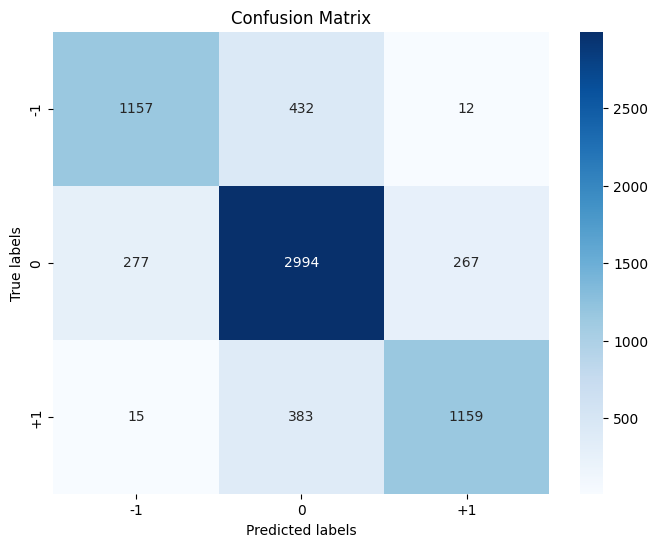

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion report
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['-1', '0', '+1'], 
            yticklabels=['-1', '0', '+1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


#### Interpretation of the results:

1. **Classes**:
   - **-1**: Represents the scenario where the price is predicted to decrease by more than 1% in the next 10 hours.
   - **0**: Represents the scenario where the price is predicted to change within a range of -1% to +1% in the next 10 hours.
   - **1**: Represents the scenario where the price is predicted to increase by more than 1% in the next 10 hours.

2. **Precision**:
   - **For class -1 (0.80)**: Out of all instances where the model predicts a greater than 1% decrease, 80% of the time, it was correct.
   - **For class 0 (0.79)**: Out of all instances where the model predicts the price to stay within a range of -1% to +1%, 79% of the time, it was correct.
   - **For class 1 (0.81)**: Out of all instances where the model predicts a greater than 1% increase, 81% of the time, it was correct.

3. **Recall**:
   - **For class -1 (0.72)**: Out of all the actual instances where the price decreased by more than 1%, the model correctly identified 72% of them.
   - **For class 0 (0.85)**: Out of all the actual instances where the price stayed within a range of -1% to +1%, the model correctly identified 85% of them.
   - **For class 1 (0.74)**: Out of all the actual instances where the price increased by more than 1%, the model correctly identified 74% of them.

4. **F1-score**:
   - **For classes -1, 0, and 1 (0.76, 0.82, 0.77)**: The F1-score is the harmonic mean of precision and recall. The closer it is to 1, the better. It gives a balanced view of the model's performance. For the model, the F1-scores are relatively high, indicating a well-performing model for each class.

5. **Accuracy (0.79)**: This indicates that the model made correct predictions 79% of the time across all classes on the test data. This is a good indication that the model is performing well.

6. **Macro Avg vs Weighted Avg**: 
   - **Macro Avg (0.78)**: This averages the unweighted mean per label. It's useful when wanting to know how the model performs individually on each class without considering the class distribution.
   - **Weighted Avg (0.79)**: This averages the support-weighted mean per label. It considers the class distribution, giving more weight to the predominant class (class 0). This is more representative of the model's overall performance.

**Summary**: 
The model appears to be performing well across all three classes. 
- The recall for class 0 (where price changes are between -1% and +1%) is the highest, indicating that the model is particularly adept at identifying this scenario. 
- Overall, with an accuracy of 79%, the model seems to be a robust predictor of price changes based on the given context and dataset. 
- However, it's also essential to assess the model's business impact and consider any potential financial risks associated with false positives or false negatives.

#### Model improvement

1. **Feature Engineering**:
   - **Technical Indicators**: For predicting price changes, technical indicators like RSI, MACD, Bollinger Bands, and others can be useful.
   - **Time Series Features**: Since this is a time-series prediction, consider lag features, rolling averages, and other time-series specific transformations.
   - **Sentiment Analysis**: Incorporate news sentiment or social media sentiment regarding the asset. Changes in sentiment can often lead to price fluctuations.

2. **Model Complexity**:
   - **Deep Learning**: RNNs, LSTMs, or GRUs can be considered as they are well-suited for sequential data like stock prices.
   - **Hybrid Models**: Combine traditional models with neural networks for better performance.

3. **Better Resampling Techniques**:
   - **ADASYN**: Similar to SMOTE but focuses on the samples which are difficult to classify.
   - **SMOTE with different ratios**: Experiment with the sampling strategy to balance the classes differently.

4. **Data Sources**:
   - **Incorporate more data**: More historical data can lead to better generalization.
   - **External Factors**: Incorporate macroeconomic indicators, or if it's a company's stock, consider their financials, quarterly reports, etc.

5. **Model Interpretability**:
   - **SHAP, LIME**: These can help in understanding which features are contributing the most to the predictions. This can give insights into the areas where the model might be going wrong.

6. **Ensemble Different Models**:
   - Besides the stacking and blending methods, consider creating diverse models and combine their predictions for a more robust result.

7. **Hyperparameter Tuning**:
   - Conduct a more exhaustive search with tools like GridSearchCV or RandomizedSearchCV.
   - Consider using Bayesian optimization for hyperparameter tuning.

8. **Evaluation Metrics**:
   - Since it's a financial context, consider evaluating not just on accuracy but also on the financial impact of the model's predictions. Metrics like expected value can be of use here.

9. **Regularization & Dropout**:
   - To prevent overfitting, regularization techniques such as L1 and L2 regularization can be applied.
   - For neural networks, using dropout layers can help in reducing over-reliance on any particular neuron and thus reduce overfitting.

10. **Outlier Detection**:
   - Financial data can sometimes have outliers due to various reasons like market manipulation, extreme news, etc. Removing or treating outliers can lead to better model performance.

11. **Feedback Loop**:
   - Consider setting up a feedback loop. As real-world predictions come in and find out if they were right or wrong, that data can be used to further train and refine the model.


----

### Experiment ?: Hyperparameter tuning

----

In [92]:
df = get_features_target_next_close()

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

# Splitting the data
drop_cols = ['datetime', 'high', 'low', 'open', 'close', 'volume', 'target']
X = df.drop(drop_cols, axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

In [93]:
# Using bagging with decision trees as the base classifier
model = RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the RandomForest Classifier: {accuracy:.2f}")

Accuracy of the RandomForest Classifier: 0.77



Classification Report:
               precision    recall  f1-score   support

          -1       0.83      0.63      0.72      1601
           0       0.74      0.89      0.81      3538
           1       0.82      0.64      0.72      1557

    accuracy                           0.77      6696
   macro avg       0.80      0.72      0.75      6696
weighted avg       0.78      0.77      0.77      6696



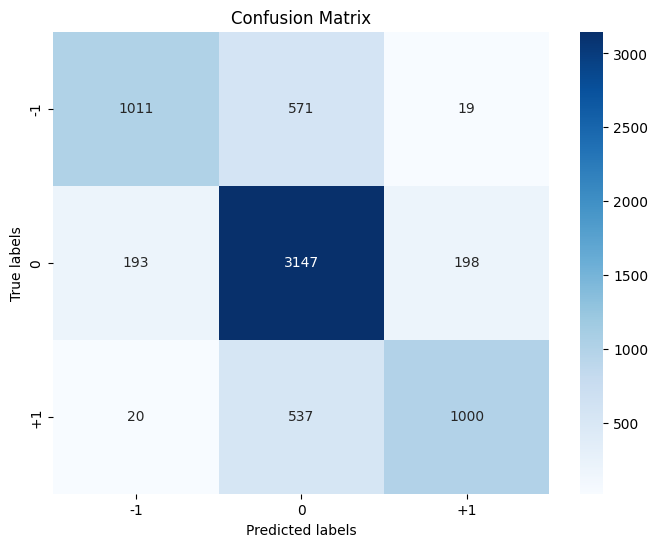

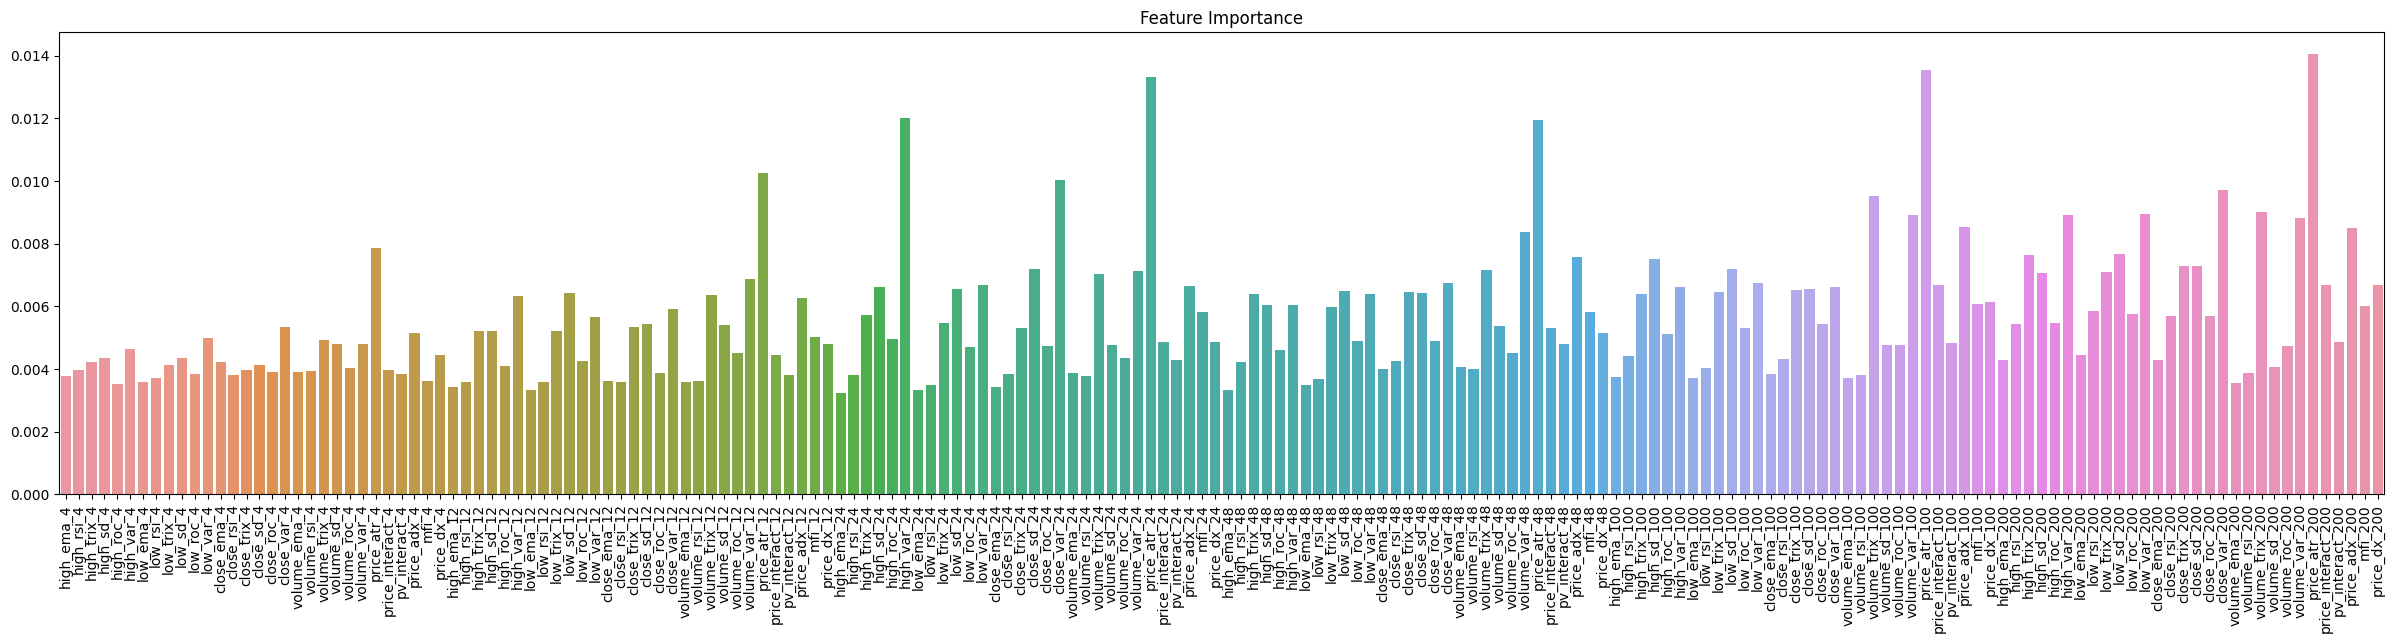

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion report
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['-1', '0', '+1'], 
            yticklabels=['-1', '0', '+1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# 2. Feature Importance
# Since our base estimator is a decision tree, we can obtain feature importances.
# We average feature importance over all the base estimators to get an average importance.

# Collecting importances from each tree
importances = np.array([tree.feature_importances_ for tree in model.estimators_])

# Averaging over trees
avg_importance = importances.mean(axis=0)

plt.figure(figsize=(30, 6))
sns.barplot(x=X.columns, y=avg_importance)
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()



----

In [96]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Using bagging with decision trees as the base classifier
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_clf.fit(X_train, y_train)

# Making predictions
y_pred = bagging_clf.predict(X_test)



In [97]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Bagging Classifier: {accuracy:.2f}")

# Accuracy of the Bagging Classifier: 0.77

Accuracy of the Bagging Classifier: 0.77


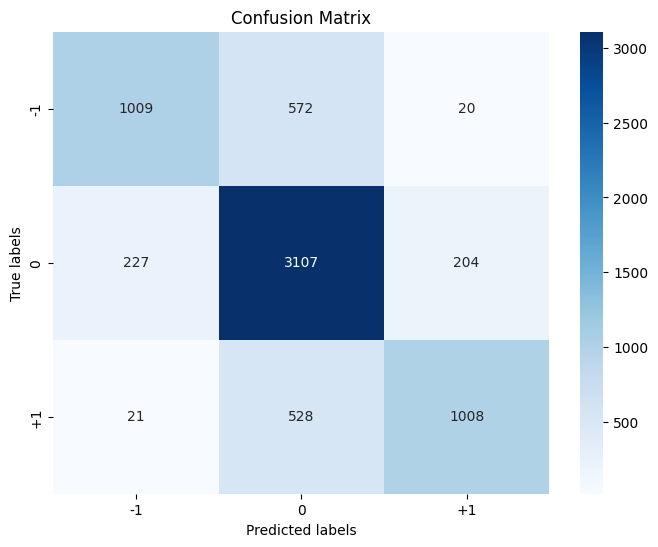

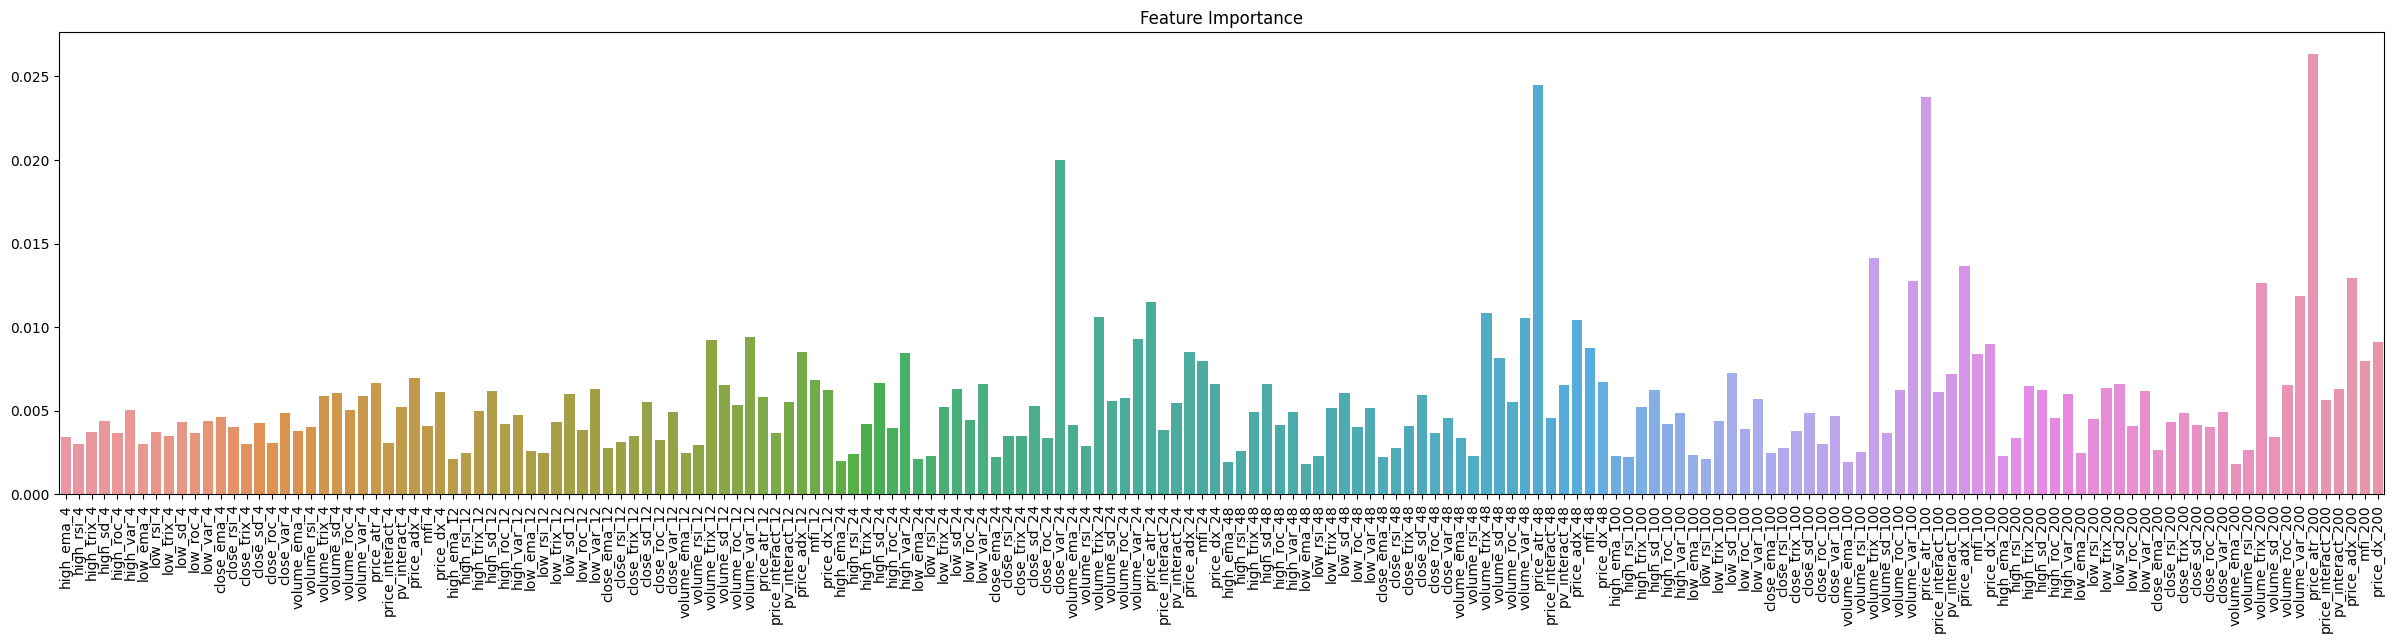

ValueError: multi_class must be in ('ovo', 'ovr')

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['-1', '0', '+1'], 
            yticklabels=['-1', '0', '+1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 2. Feature Importance
# Since our base estimator is a decision tree, we can obtain feature importances.
# We average feature importance over all the base estimators to get an average importance.

# Collecting importances from each tree
importances = np.array([tree.feature_importances_ for tree in bagging_clf.estimators_])

# Averaging over trees
avg_importance = importances.mean(axis=0)

plt.figure(figsize=(30, 6))
sns.barplot(x=X.columns, y=avg_importance)
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

# 3. ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, y_pred)

# Calculate roc curves
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC curve (area = {roc_value:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


----
## Note:

In [ ]:
# select only features with importance > 0.01
selected_features = X_train.columns[(importances > np.mean(importances))]
# selected_features = X_train.columns[(importances > 0.005)]
print(len(selected_features))
print(selected_features)

In [ ]:
# import talib
# import numpy as np

# def get_features():
#     # df = pd.read_csv('./data/BTCUSDT_1h.csv') 
#     df = read_hist_data()

    

#     # List of periods
#     periods = [4, 12, 24, 48, 100, 200]

#     # loop through periods
#     for period in periods:

#         # Price indicators
#         # price % of ema
#         p_ema = talib.EMA(df['close'].values, timeperiod=period)
#         df[f'p_ema_{period}'] = (df['close'] - p_ema) / p_ema * 100

#         # RSI
#         df[f'p_rsi_{period}'] = talib.RSI(df['close'].values, timeperiod=period)

#         # TRIX
#         df[f'p_trix_{period}'] = talib.TRIX(df['close'].values, timeperiod=period)

#         # SD
#         p_sd = talib.STDDEV(df['close'].values, timeperiod=period)
#         df[f'p_sd_{period}'] = p_sd / df['close'] * 100

#         # ATR
#         p_atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
#         df[f'p_atr_{period}'] = p_atr / df['close'] * 100

#         # ROC
#         df[f'p_roc_{period}'] = talib.ROC(df['close'].values, timeperiod=period)

#         # Interaction Features:
#         df[f'p_interaction_{period}'] = df[f'p_roc_{period}'] * df[f'p_atr_{period}']


#         # Volume indicators
#         v_ema = talib.EMA(df['volume'], timeperiod=period)

#         # volume % of ema
#         df[f'v_ema_{period}'] = (df['volume'] - v_ema) / v_ema * 100

#         # RSI
#         df[f'v_rsi_{period}'] = talib.RSI(df['volume'].values, timeperiod=period)

#         # ROC
#         df[f'v_roc_{period}'] = talib.ROC(df['volume'].values, timeperiod=period)

#         # price volume interaction
#         df[f'pv_interaction_{period}'] = df[f'p_roc_{period}'] * df[f'v_roc_{period}']

#         # ==================== #

#         # ADX
#         df[f'p_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

#         # # CCI
#         # df[f'p_cci_{period}'] = talib.CCI(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

#         # MFI
#         # df[f'p_mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

#         # OBV
#         # obv = talib.OBV(df['close'].values, df['volume'].values)
#         # avg_obv = talib.EMA(obv, timeperiod=period)
#         # df[f'p_obv_ref_{period}'] = (obv - avg_obv) / avg_obv * 100

#         # DX
#         df[f'p_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

#         # df[f'p_dm-_{period}'] = talib.MINUS_DM(df['high'].values, df['low'].values, timeperiod=period)
#         # df[f'p_dm+_{period}'] = talib.PLUS_DM(df['high'].values, df['low'].values, timeperiod=period)

#         # VAR
#         df[f'p_var_{period}'] = talib.VAR(df['close'].values, timeperiod=period)



#     return df

# def get_target_next_close(df, target_shift = 10):
#     target_treshold = 0.01
#     conditions = [
#         (df['close'].shift(target_shift * -1) > df['close'] * (1+target_treshold )),
#         (df['close'].shift(target_shift * -1) < df['close'] * (1-target_treshold)),
#         (df['close'].shift(target_shift * -1) >= df['close'] * (1-target_treshold)) & 
#         (df['close'].shift(target_shift * -1) <= df['close'] * (1+target_treshold))
#     ]
#     values = [1, -1, 0]
#     df['target'] = np.select(conditions, values)
#     df = df.dropna()
#     return df
    

# df = get_features()
# df = get_target_next_close(df)
# print(df.head(10))
# print(df.tail(10))

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# # from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
# from sklearn.tree import DecisionTreeClassifier

# # Initialize n_jobs option
# use_parallel = True  # Set to False if you don't want to use parallel processing
# random_state = 55

# # Define models
# models = [
#     ('LogisticRegression', LogisticRegression(random_state=random_state, max_iter=1000, n_jobs=-1 if use_parallel else None)),
#     ('KNN', KNeighborsClassifier(n_jobs=-1 if use_parallel else None)),
#     ('SVM', SVC(kernel='linear', random_state=random_state, max_iter=10000)),
#     # ('RandomForest', RandomForestClassifier(random_state=random_state, n_jobs=-1 if use_parallel else None)),
#     # ('ExtraTrees', ExtraTreesClassifier(random_state=random_state, n_jobs=-1 if use_parallel else None)),
#     # ('GradientBoosting', GradientBoostingClassifier(random_state=random_state)),
#     ('DecisionTree', DecisionTreeClassifier(random_state=random_state, n_jobs=-1 if use_parallel else None))
# ]

# # Test each model
# for name, model in models:
#     pipeline = Pipeline([
#         ('model', model)
#     ])
#     scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy')
#     print(scores)
#     print(f"{name}: Mean Accuracy: {scores.mean():.2f}, Standard Deviation: {scores.std():.2f}")


In [ ]:

# # Pipelines to test multiple models
# models = [
#     ('DecisionTree', DecisionTreeClassifier(random_state=42)),
#     ('BaggingClassifier', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)),
#     ('SVM', SVC(kernel='linear', random_state=42, max_iter=10000)),
#     ('LogisticRegression', LogisticRegression(random_state=42))
# ]

# for name, model in models:
#     pipeline = Pipeline([
#         ('model', model)
#     ])
#     scores = cross_val_score(pipeline, X_train_smote, y_train_smote, cv=cv, scoring='accuracy')
#     print(scores)
#     print(f"{name}: Mean Accuracy: {scores.mean():.2f}, Standard Deviation: {scores.std():.2f}")